# Project 1: Galaxy Zoo

In [1]:
from fastai.vision import *

In [3]:
from galaxy import GalaxyOutput

In [4]:
import pandas as pd

In [5]:
#path = Config.data_path() / 'galaxyzoo'
path = Path('/storage') / 'galaxyzoo'

In [6]:
path.ls()

[PosixPath('/storage/galaxyzoo/all_ones_benchmark.zip'),
 PosixPath('/storage/galaxyzoo/all_ones_benchmark.csv'),
 PosixPath('/storage/galaxyzoo/central_pixel_benchmark.csv'),
 PosixPath('/storage/galaxyzoo/images_training_rev1.zip'),
 PosixPath('/storage/galaxyzoo/training_solutions_rev1.zip'),
 PosixPath('/storage/galaxyzoo/images_test_rev1'),
 PosixPath('/storage/galaxyzoo/images_test_rev1.zip'),
 PosixPath('/storage/galaxyzoo/images_training_rev1'),
 PosixPath('/storage/galaxyzoo/central_pixel_benchmark.zip'),
 PosixPath('/storage/galaxyzoo/all_zeros_benchmark.csv'),
 PosixPath('/storage/galaxyzoo/all_zeros_benchmark.zip'),
 PosixPath('/storage/galaxyzoo/training_solutions_rev1.csv'),
 PosixPath('/storage/galaxyzoo/models')]

__How to load the data__

- Data is in a folder
- Data is split by folder into train and test
- For training we maybe just split the train dataset by percentage and leave their test set as a genuine hold-out set.
- the labels are found in csv files for train and test
- the labels are actually a categorial distribution of user responses to the the images so we have to either take the max of that or we could even set the vector as the objective. Both would be interesting experiments.
- Data augmentation - flipping and rotating and warping should be okay. warping perhaps not.

In [7]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, xtra_tfms=rand_pad(10, 128))

In [8]:
type(tfms)

tuple

In [9]:
labels = pd.read_csv(path/'training_solutions_rev1.csv')

In [10]:
labels.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [11]:
src = (ImageList.from_csv(path,
                           'training_solutions_rev1.csv', 
                           folder='images_training_rev1', 
                           suffix='.jpg',
                           cols=0,)
            .split_by_rand_pct(0.2)
            .label_from_df(cols=list(range(1, 38)), label_cls=FloatList))
data = (src.transform(tfms, size=128)
           .databunch()).normalize(imagenet_stats)

In [12]:
tfms[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

In [13]:
tfms_flat = list(itertools.chain.from_iterable(tfms))

In [14]:
len(tfms_flat)

9

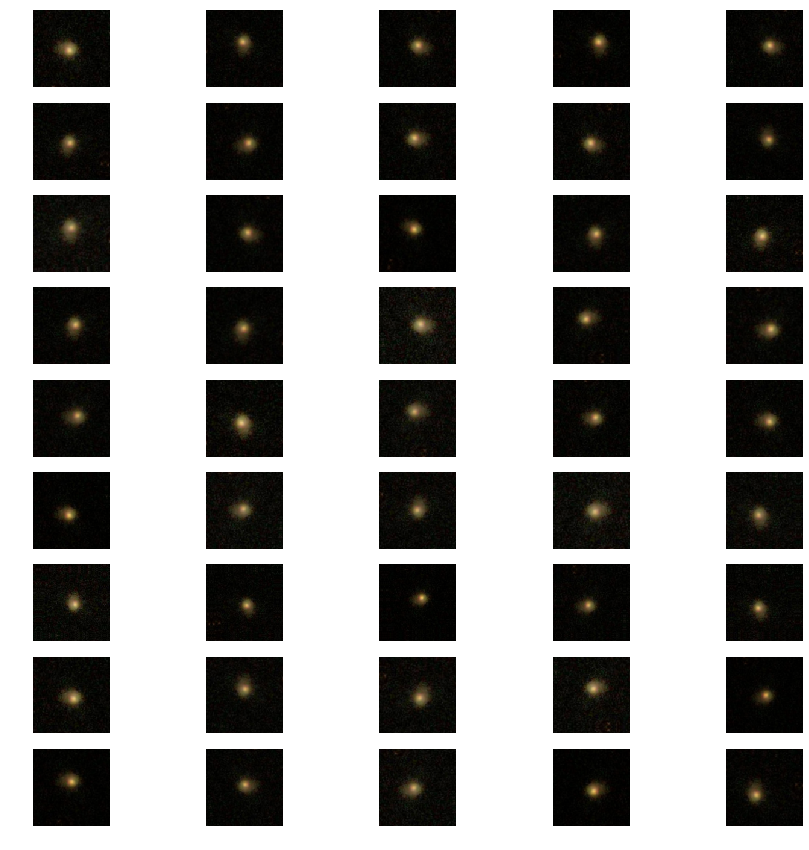

In [15]:
fig, axes = plt.subplots(nrows=len(tfms_flat), ncols=5, figsize=(15, 15))

for i, tfm in enumerate(tfms_flat):
    for j in range(5):
        ax = axes[i, j]
        img = data.train_ds[3][0].apply_tfms(tfm)
        img.show(ax=ax)

/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


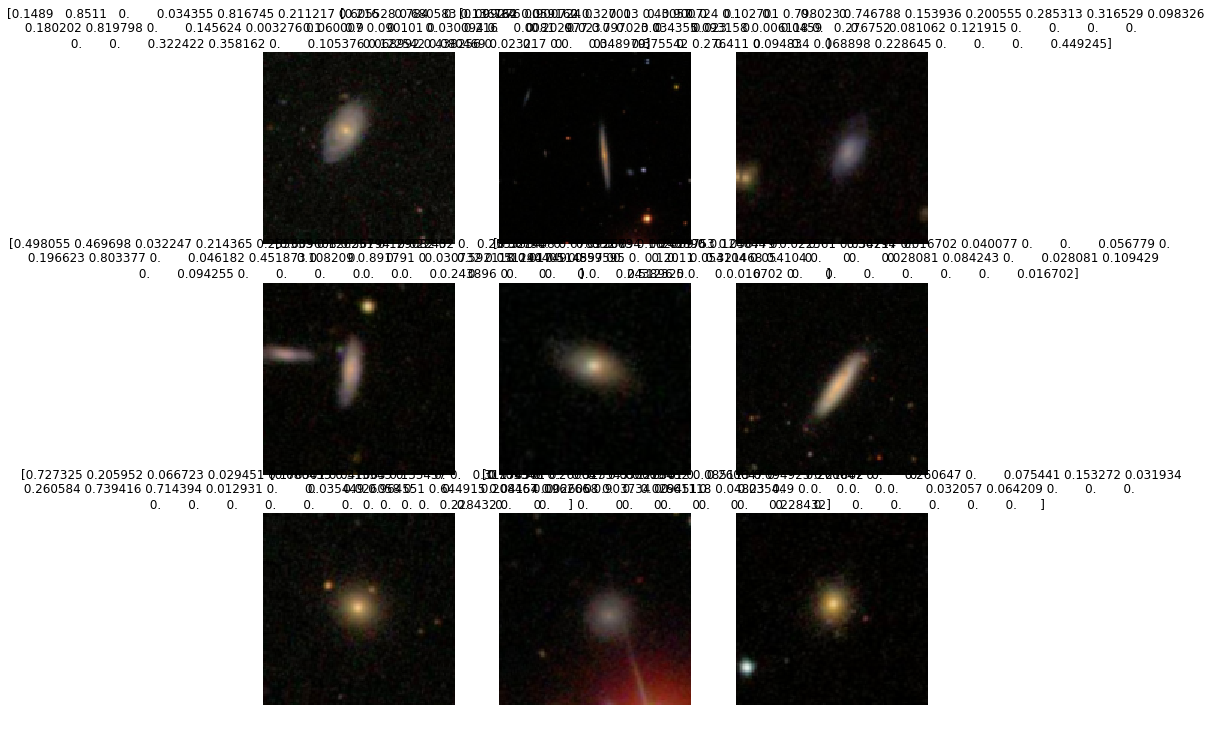

In [16]:
data.show_batch(3)

In [22]:
learner = cnn_learner(data, models.resnet34, metrics=rmse, ps=0.4)
learner.model[-1] = nn.Sequential(*learner.model[-1], GalaxyOutput())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


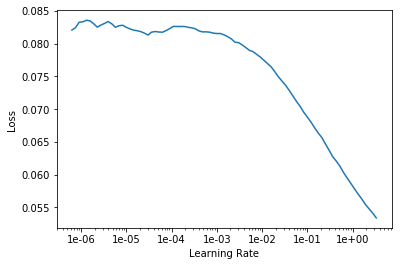

In [24]:
learner.lr_find()
learner.recorder.plot()

In [25]:
lr = 1e-2

In [26]:
learner.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.014885,0.013774,0.117171,02:47
1,0.012299,0.011860,0.108726,02:50


In [27]:
learner.save('stage-resnet34-1')

In [28]:
learner.unfreeze()

In [29]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


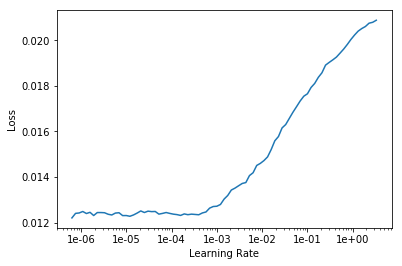

In [30]:
learner.recorder.plot()

In [31]:
learner.fit_one_cycle(5, slice(1e-5, 5e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.011411,0.011199,0.105703,02:56
1,0.010289,0.009903,0.099364,02:50
2,0.009630,0.009362,0.096619,02:52
3,0.009213,0.008932,0.094389,02:52
4,0.008879,0.008712,0.093219,02:52


In [32]:
learner.save('stage-resnet34-2')

In [33]:
learner.load('stage-resnet34-2');

In [34]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, xtra_tfms=rand_pad(6, 224))

In [35]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

learner.data = data
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [36]:
learner.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


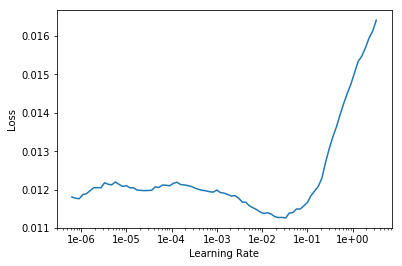

In [37]:
learner.lr_find()
learner.recorder.plot()

In [38]:
lr = 1e-3

In [40]:
learner.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.009528,0.008863,0.094006,03:36
1,0.008971,0.008660,0.092919,03:35


In [41]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


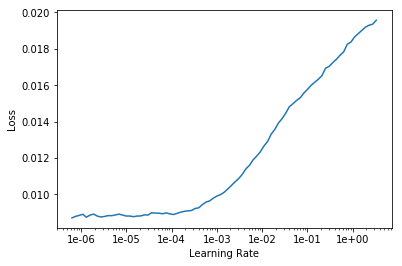

In [42]:
learner.lr_find()
learner.recorder.plot()

In [43]:
lr = 1e-4

In [44]:
learner.fit_one_cycle(5, slice(1e-5, lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.008710,0.008385,0.091446,04:43
1,0.008412,0.008043,0.089553,04:41
2,0.008047,0.007734,0.087833,04:42
3,0.007742,0.007490,0.086434,04:42
4,0.007678,0.007438,0.086129,04:43


In [45]:
learner.save('stage-resnet34-224-3')

In [ ]:
learner.fit_one_cycle(5, slice(1e-5/2, lr/5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007166,0.008596,0.088354,04:33
1,0.007090,0.006991,0.083122,04:33
2,0.007042,0.006679,0.081603,04:34
3,0.006905,0.006578,0.080971,04:33


In [228]:
learner.validate()

[0.006626785, tensor(0.0812)]

In [229]:
learner.save('stage-resnet50-224-4')

In [81]:
learner.load('stage-resnet50-224-4');

In [78]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


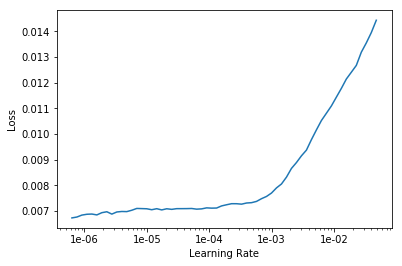

In [79]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr = 5e-5

In [82]:
learner.fit_one_cycle(1, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007061,0.090079,0.129032,04:32


In [55]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, xtra_tfms=rand_pad(16, 424))

In [56]:
data = (src.transform(tfms, size=424)
        .databunch(bs=32).normalize(imagenet_stats))

learner.data = data
data.train_ds[0][0].shape

torch.Size([3, 424, 424])

In [57]:
learner.freeze()

In [52]:
learner.lr_find()
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 351.12 MiB (GPU 0; 15.90 GiB total capacity; 14.36 GiB already allocated; 55.88 MiB free; 268.04 MiB cached)

In [58]:
lr = 1e-3

In [59]:
learner.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time


KeyboardInterrupt: 